## Importing Libraries

In [37]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Importing the Data

In [38]:
df_listings = pd.read_pickle('../data/interim/df_listings.pkl')

## Data Modeling

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

In [39]:
pd.set_option('display.max_columns', None)

df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,1.0,0.90,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1.0,1.0,3.0,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",105.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,33,63,338,2021-01-04,192,6,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,1.0,0.75,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1.0,1.0,0.0,"[""Long term stays allowed"", ""Lock on bedroom d...",40.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,30,60,90,365,2020-12-18,21,1,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,NaN,1.00,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1.0,1.0,1.0,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",75.0,10,50,10.0,10.0,50.0,50.0,10.0,50.0,NaN,t,29,59,62,189,202

#### Removing Features

In [40]:
def drop_columns(df):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','scrape','first_review','last_review','cancellation_policy','requires']
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['id','name','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','calendar_updated','host_id', 'host_name', 
                          'host_since', 'host_location', 'host_about','host_response_time',
                          'host_response_rate', 'host_acceptance_rate', 
                          'host_neighbourhood', 'host_listings_count',
                          'host_has_profile_pic', 'host_identity_verified',
                          'minimum_minimum_nights', 'maximum_nights_avg_ntm',
                          'maximum_minimum_nights', 'minimum_maximum_nights',
                          'maximum_maximum_nights', 'minimum_nights_avg_ntm'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

df_listings = drop_columns(df_listings)

In [41]:
#df = df[df['bathrooms_text'].notna()]
df_listings.rename(columns={'bathrooms_text': 'bathrooms_shared'}, inplace=True)

In [42]:
df_listings.columns

Index(['host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_shared', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object')

#### Feature Engineering

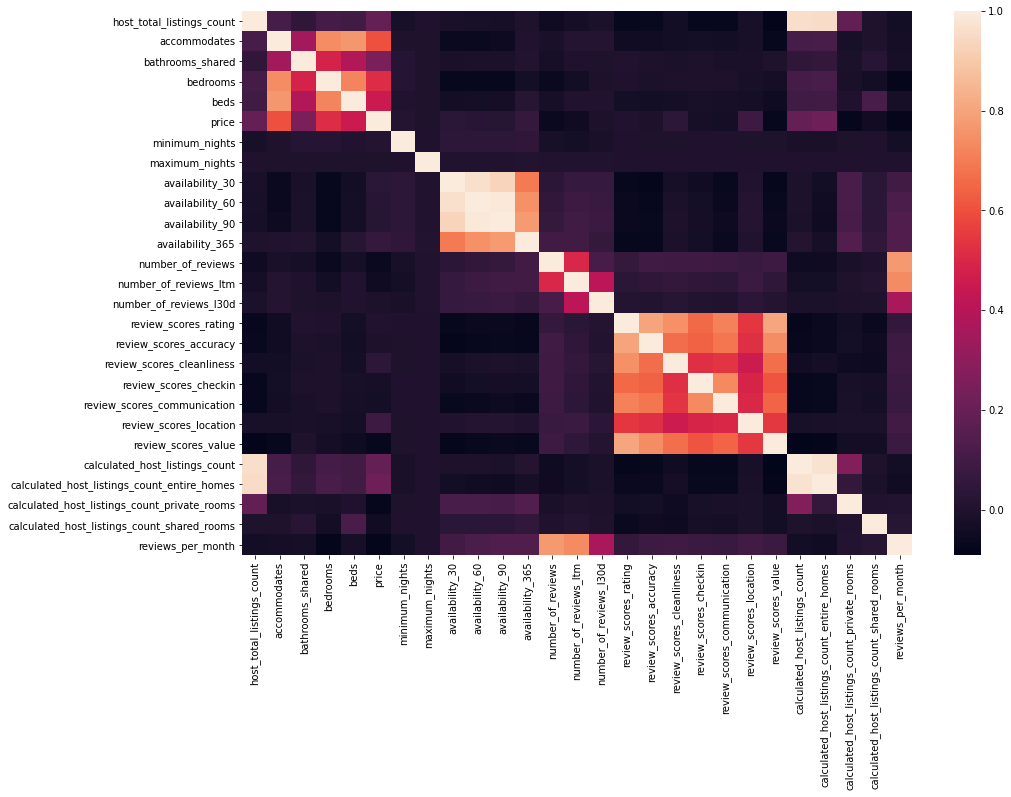

In [43]:
# calculate the correlation matrix
corr = df_listings.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [44]:
# Checking labels for the object type data
for col in df_listings.select_dtypes(include=['object']).columns:
    print(col, ': ', len(df_listings[col].unique()), 'labels')

host_is_superhost :  3 labels
host_verifications :  535 labels
neighbourhood_cleansed :  33 labels
property_type :  89 labels
room_type :  4 labels
amenities :  67099 labels
has_availability :  2 labels
instant_bookable :  2 labels


In [45]:
# Checking Property Type labels
df_property_type = df_listings["property_type"].value_counts()

In [46]:
# Amenities expansion to label encoding
df_listings["amenities"] = df_listings["amenities"].apply(eval)

In [47]:
# host_verifications expansion to label encoding
df_listings["host_verifications"] = df_listings["host_verifications"].apply(eval)

In [48]:
df_listings['amenities_len'] = df_listings['amenities'].str.len()
df_listings['verifications_len'] = df_listings['host_verifications'].str.len()

del df_listings['host_verifications']

In [49]:
# Creating new property type column
df_listings["property_type"] = df_listings["property_type"].str.split().str[-1]

In [50]:
# Function for creating 1D series
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [51]:
df_amenities_top_10 = pd.DataFrame(to_1D(df_listings["amenities"]).value_counts().head(50)).index

df_amenities_top_10

Index(['Wifi', 'Heating', 'Essentials', 'Kitchen', 'Smoke alarm', 'Washer',
       'Hangers', 'Iron', 'TV', 'Hair dryer', 'Shampoo', 'Dedicated workspace',
       'Carbon monoxide alarm', 'Hot water', 'Dryer', 'Refrigerator',
       'Dishes and silverware', 'Cooking basics', 'Oven', 'Bed linens',
       'Microwave', 'Stove', 'Fire extinguisher', 'First aid kit',
       'Private entrance', 'Dishwasher', 'Long term stays allowed',
       'Coffee maker', 'Free parking on premises', 'Elevator',
       'Lock on bedroom door', 'Extra pillows and blankets', 'Host greets you',
       'Cable TV', 'Luggage dropoff allowed', 'Patio or balcony',
       'Garden or backyard', 'Breakfast', 'Paid parking off premises',
       'Lockbox', 'Free street parking', 'Bathtub', 'Shower gel',
       'Indoor fireplace', 'Single level home', 'Air conditioning',
       'High chair', 'Paid parking on premises', 'Private living room',
       'Children’s books and toys'],
      dtype='object')

In [52]:
#df_verifications_top_10 = pd.DataFrame(to_1D(df_listings["host_verifications"]).value_counts().head(10)).index

#df_listings["host_verifications"]

In [53]:
df_new_property_top_10 = pd.DataFrame(df_listings["property_type"].value_counts().head(20)).index

df_new_property_top_10

Index(['apartment', 'house', 'townhouse', 'condominium', 'loft', 'breakfast',
       'hotel', 'suite', 'guesthouse', 'hostel', 'bungalow', 'aparthotel',
       'room', 'cottage', 'Boat', 'home/apt', 'villa', 'place', 'cabin',
       'Houseboat'],
      dtype='object')

In [54]:
def onehot_df(df, variable, unique_items):
    
    item_lists = df[variable]
    
    # Loop through all the labels
    for i, label in enumerate(unique_items):
        
        # Creating new column for each label
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    
    # Removing old column
    del df[variable]
            
    # Return the results as a dataframe
    return df

In [55]:
onehot_df(df_listings,"amenities", df_amenities_top_10)

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_shared,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_len,verifications_len,amenities_Wifi,amenities_Heating,amenities_Essentials,amenities_Kitchen,amenities_Smoke alarm,amenities_Washer,amenities_Hangers,amenities_Iron,amenities_TV,amenities_Hair dryer,amenities_Shampoo,amenities_Dedicated workspace,amenities_Carbon monoxide alarm,amenities_Hot water,amenities_Dryer,amenities_Refrigerator,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Oven,amenities_Bed linens,amenities_Microwave,amenities_Stove,amenities_Fire extinguisher,amenities_First aid kit,amenities_Private entrance,amenities_Dishwasher,amenities_Long term stays allowed,amenities_Coffee maker,amenities_Free parking on premises,amenities_Elevator,amenities_Lock on bedroom door,amenities_Extra pillows and blankets,amenities_Host greets you,amenities_Cable TV,amenities_Luggage dropoff allowed,amenities_Patio or balcony,amenities_Garden or backyard,amenities_Breakfast,amenities_Paid parking off premises,amenities_Lockbox,amenities_Free street parking,amenities_Bathtub,amenities_Shower gel,amenities_Indoor fireplace,amenities_Single level home,amenities_Air conditioning,amenities_High chair,amenities_Paid parking on premises,amenities_Private living room,amenities_Children’s books and toys
0,f,3.0,Lambeth,apartment,Entire home/apt,4,1.0,1.0,3.0,105.0,2,1125,t,3,33,63,338,192,6,0,91.0,9.0,9.0,10.0,10.0,9.0,9.0,t,2,2,0,0,1.46,28,8.0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
1,f,3.0,Islington,apartment,Private room,2,1.0,1.0,0.0,40.0,1,29,t,30,60,90,365,21,1,0,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,2,1,1,0,0.17,41,7.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1
2,f,1.0,Kensington and Chelsea,apartment,Entire home/apt,2,1.0,1.0,1.0,75.0,10,50,t,29,59,62,189,89,1,0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,t,1,1,0,0,0.66,24,5.0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,f,3.0,Hammersmith and Fulham,townhouse,Private room,2,1.0,1.0,1.0,150.0,3,21,t,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN,16,7.0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
4,t,3.0,Barnet,house,Private room,2,1.5,1.0,0.0,29.0,10,1120,t,0,0,0,2,129,3,0,96.0,10.0,10.0,10.0,10.0,9.0,10.0,t,3,0,3,0,0.99,14,7.0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71818,f,0.0,Camden,condominium,Entire home/apt,1,1.5,1.0,0.0,52.0,7,365,t,10,40,66,66,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN,14,7.0,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
71819,t,191.0,Lewisham,house,Entire home/apt,4,1.0,2.0,2.0,111.0,2,100,t,27,57,87,87,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,16,16,0,0,NaN,21,4.0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
71820,f,13.0,Westminster,

In [56]:
#onehot_df(df_listings,"host_verifications", df_verifications_top_10)

In [57]:
onehot_df(df_listings,"property_type", list(df_new_property_top_10))

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms_shared,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_len,verifications_len,amenities_Wifi,amenities_Heating,amenities_Essentials,amenities_Kitchen,amenities_Smoke alarm,amenities_Washer,amenities_Hangers,amenities_Iron,amenities_TV,amenities_Hair dryer,amenities_Shampoo,amenities_Dedicated workspace,amenities_Carbon monoxide alarm,amenities_Hot water,amenities_Dryer,amenities_Refrigerator,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Oven,amenities_Bed linens,amenities_Microwave,amenities_Stove,amenities_Fire extinguisher,amenities_First aid kit,amenities_Private entrance,amenities_Dishwasher,amenities_Long term stays allowed,amenities_Coffee maker,amenities_Free parking on premises,amenities_Elevator,amenities_Lock on bedroom door,amenities_Extra pillows and blankets,amenities_Host greets you,amenities_Cable TV,amenities_Luggage dropoff allowed,amenities_Patio or balcony,amenities_Garden or backyard,amenities_Breakfast,amenities_Paid parking off premises,amenities_Lockbox,amenities_Free street parking,amenities_Bathtub,amenities_Shower gel,amenities_Indoor fireplace,amenities_Single level home,amenities_Air conditioning,amenities_High chair,amenities_Paid parking on premises,amenities_Private living room,amenities_Children’s books and toys,property_type_apartment,property_type_house,property_type_townhouse,property_type_condominium,property_type_loft,property_type_breakfast,property_type_hotel,property_type_suite,property_type_guesthouse,property_type_hostel,property_type_bungalow,property_type_aparthotel,property_type_room,property_type_cottage,property_type_Boat,property_type_home/apt,property_type_villa,property_type_place,property_type_cabin,property_type_Houseboat
0,f,3.0,Lambeth,Entire home/apt,4,1.0,1.0,3.0,105.0,2,1125,t,3,33,63,338,192,6,0,91.0,9.0,9.0,10.0,10.0,9.0,9.0,t,2,2,0,0,1.46,28,8.0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,f,3.0,Islington,Private room,2,1.0,1.0,0.0,40.0,1,29,t,30,60,90,365,21,1,0,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,2,1,1,0,0.17,41,7.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,f,1.0,Kensington and Chelsea,Entire home/apt,2,1.0,1.0,1.0,75.0,10,50,t,29,59,62,189,89,1,0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,t,1,1,0,0,0.66,24,5.0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,f,3.0,Hammersmith and Fulham,Private room,2,1.0,1.0,1.0,150.0,3,21,t,29,59,89,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN,16,7.0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,t,3.0,Barnet,Private room,2,1.5,1.0,0.0,29.0,10,1120,t,0,0,0,2,129,3,0,96.0,10.0,10.0,10.0,10.0,9.0,10.0,t,3,0,3,0,0.99,14,7.0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [58]:
# Confirming the shape of the df_listings
df_listings.shape

(71823, 104)

In [59]:
# Removing any rows with NaN values
df_listings = df_listings.dropna()

In [60]:
# Confirming there are no rows with NaN values
df_listings.isnull().sum()

host_is_superhost            0
host_total_listings_count    0
neighbourhood_cleansed       0
room_type                    0
accommodates                 0
                            ..
property_type_home/apt       0
property_type_villa          0
property_type_place          0
property_type_cabin          0
property_type_Houseboat      0
Length: 104, dtype: int64

In [61]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df_listings = df_listings[df_listings['price'] != 0]

#### Train / Test split

In [62]:
# Extract features and labels
X = df_listings.drop("price", axis=1) # drop labels for training set
y = df_listings["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32651, 103)
(13994, 103)
(32651,)
(13994,)


In [65]:
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

#### Data selector 

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

#### Creating the Pipeline

In [67]:
num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [68]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),
    ])

In [69]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [70]:
from sklearn.pipeline import FeatureUnion

full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [71]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [72]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(32651, 141)
(13994, 141)


## Model Evaluation

### Base Evaluation - Fittng the training data with various models

In [37]:
import time

def base_models(model, X_train, X_test, y_train, y_test):
    
    start_time = time.time()
   
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predict_train)
    rmse_train = np.sqrt(mse_train)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    
    print("RMSE: Train data " + str(round(rmse_train,2)))

In [38]:
# Linear Regression - Base Model
lm = LinearRegression(n_jobs=-1)
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.036 minutes ---
RMSE: Train data 31.93


In [39]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.009 minutes ---
RMSE: Train data 31.93


In [40]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.434 minutes ---
RMSE: Train data 0.0


In [41]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_jobs=-1,random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 5.88 minutes ---
RMSE: Train data 11.47


In [42]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(random_state=42)
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.36 minutes ---
RMSE: Train data 30.64


In [43]:
# XGBRegressor - Base Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
base_models(xg_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.091 minutes ---
RMSE: Train data 23.39


### Fine tune the model with cross-validation

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def display_scores(model, X_train, y_train):
    
    #cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    cv = 5
    
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [45]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

--- 0.037 minutes ---
RMSE Scores: [31.61125737 32.05148158 32.61793056 32.35966599 31.89238704]
RMSE Mean: 32.106544508122
Standard deviation of RMSE scores: 0.35207694617848295


In [46]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

--- 20.415 minutes ---
RMSE Scores: [29.85798241 31.09093217 31.21718802 31.23602465 30.88668384]
RMSE Mean: 30.857762217170794
Standard deviation of RMSE scores: 0.5151764220376944


In [47]:
# Gradient Boosting Regressor - CV Model
display_scores(xg_reg, X_train_prepared, y_train)

--- 0.317 minutes ---
RMSE Scores: [28.95914412 30.30516639 30.28195593 30.07678397 29.78078807]
RMSE Mean: 29.880767695895496
Standard deviation of RMSE scores: 0.49776993858111557


### Comparing the Train and Test scores

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

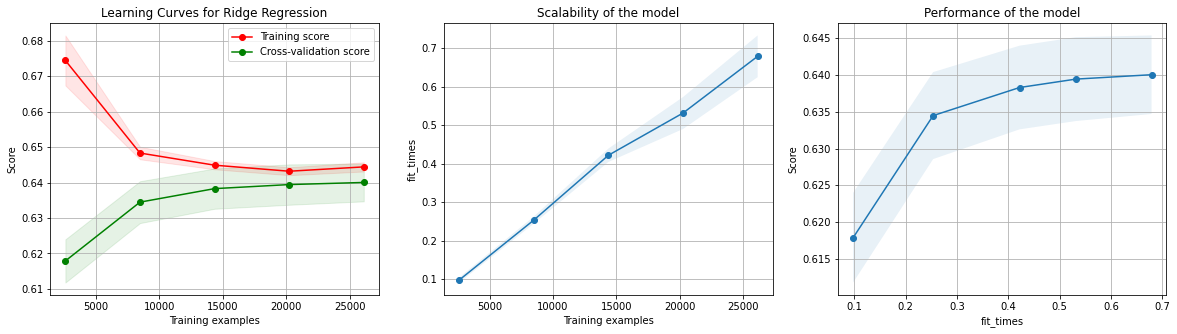

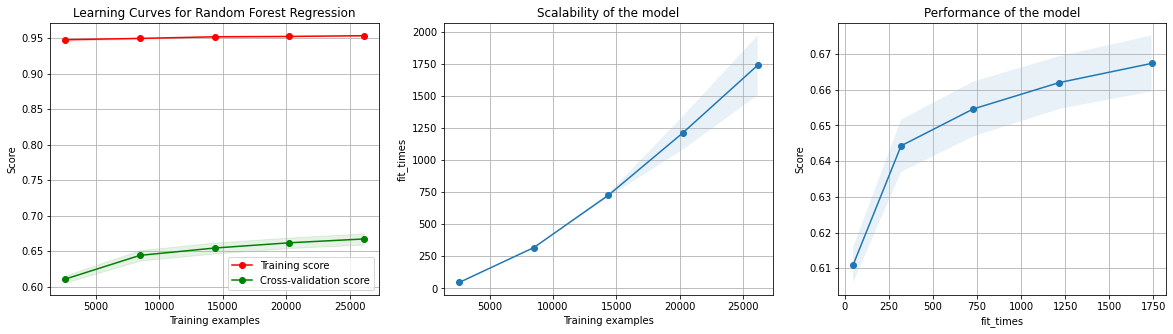

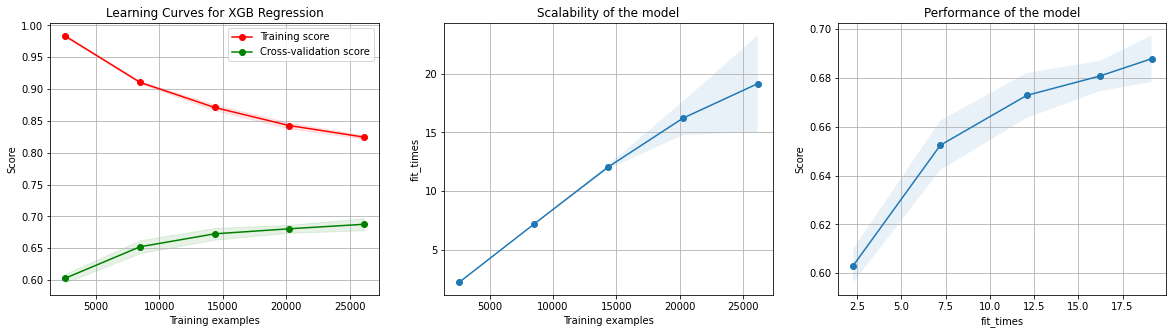

In [51]:
# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge()
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=5, n_jobs=5)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

# Gradient Boosting Regressor:
title = r"Learning Curves for XGB Regression"
estimator= xgb.XGBRegressor(objective ='reg:squarederror')
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

plt.show()

### Fine tunning the model

In [37]:
xgb1 = xgb.XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [7, 8, 9],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [38]:
xgb_grid.fit(X_train_prepared,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 69.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [7, 8, 9], 'min_chi

In [39]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7054177850899948
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [40]:
pred_x = xgb_grid.predict(X_test_prepared)

In [41]:
mse = mean_squared_error(y_test,pred_x)

In [42]:
rmse = np.sqrt(mse)

In [43]:
rmse

30.52617560259172

## Feature Importance

In [73]:
xgb2 = xgb.XGBRegressor(colsample_bytree = 0.7, 
                        learning_rate = 0.05, 
                        max_depth = 7, 
                        min_child_weight = 4, 
                        n_estimators = 500, 
                        nthread = 4, 
                        objective = 'reg:squarederror', 
                        silent = 1, 
                        subsample = 0.7)

In [74]:
xgb2.fit(X_train_prepared,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [75]:
# feature importance
print(xgb2.feature_importances_)

[0.00438707 0.01566386 0.03291502 0.01975249 0.00249802 0.00244996
 0.00334578 0.00386191 0.00443955 0.00376734 0.00285675 0.00211691
 0.00316369 0.00342854 0.00248029 0.00215224 0.00319258 0.00238664
 0.00238596 0.00739706 0.00295314 0.00375403 0.00825195 0.00410782
 0.00607979 0.00257778 0.00211529 0.00254647 0.00230359 0.00256336
 0.0046275  0.00246933 0.00224462 0.0022319  0.00241023 0.00282209
 0.00718144 0.00347103 0.00288192 0.00222516 0.00215258 0.00250643
 0.00559546 0.0024106  0.00174845 0.00205776 0.00230675 0.00220019
 0.00217226 0.00186891 0.00220947 0.00212713 0.00203025 0.00734198
 0.00194738 0.00392749 0.0031782  0.0034086  0.00211037 0.00223742
 0.00208251 0.00227583 0.00214072 0.00208235 0.0019303  0.0020702
 0.00273925 0.00272507 0.00518767 0.00208064 0.00218738 0.00402224
 0.00184072 0.00612492 0.00369841 0.00269946 0.00158815 0.00270332
 0.00183873 0.003194   0.00233683 0.00234252 0.00322685 0.00316226
 0.00959588 0.00253035 0.00080291 0.00395439 0.0004741  0.00101

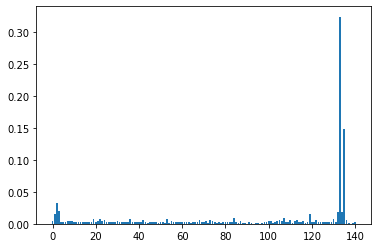

In [77]:
# plot
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()

In [78]:
import sklearn

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [79]:
attributes = list(get_feature_names(cat_pipeline)) + num_attribs

In [81]:
# Top ten features on importance
sorted(zip(xgb2.feature_importances_,attributes),reverse=True)[:10]

[(0.3246833, 'property_type_suite'),
 (0.1480986, 'property_type_hostel'),
 (0.032915022, 'selector__room_type'),
 (0.019752493, 'selector__has_availability'),
 (0.018543068, 'property_type_guesthouse'),
 (0.017772589, 'property_type_hotel'),
 (0.015722068, 'amenities_Indoor fireplace'),
 (0.015663859, 'selector__neighbourhood_cleansed'),
 (0.00959588, 'amenities_TV'),
 (0.00839201, 'amenities_Extra pillows and blankets')]